# Analyzing the percentage of scheduled vs utilization

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_num(in_str: str, shorten=False):
    '''
    :param in_str:
    :return: just returns a single consecutive digit
    '''
    num = ""

    for s in in_str:
        if s.isdigit():
            num += s

    if shorten:
        num = num[:-1]
    return int(num)


## Getting Utilization per graph

In [113]:
util_dir = "../utilization/3-phase-data-smaller/"
util_dags = os.listdir(util_dir)

utils = {}
for dag in util_dags:
    if "DAG" not in dag:
        continue

    with open((os.path.join(util_dir, dag, "utilization.txt")), "r") as file:
        line = file.read().split(" ")
        utils[dag] = float(line[1])

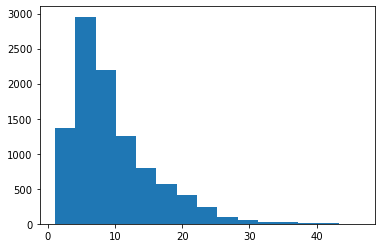

In [114]:
plt.hist(utils.values(), bins=15)
plt.show()

## Getting managed to schedule yes/no for hFLS



In [107]:
three_phase_dir = "../3-phase-data-smaller/"

three_phase_dags = os.listdir(three_phase_dir)
# target_files = ["hFLS_output_000_crpd.txt", "hFLS_output_001_crpd.txt", "hFLS_output_005.txt", "hFLS_output_010_crpd.txt", "hFLS_output_015_crpd.txt", "hFLS_output_020_completion_time.txt", ".tey", "SINGLE_PHASE.txt"]
# target_files = ["hFLS_output_020_completion_time.txt", "hFLS_output_020_makespan.txt", ".tey", "SINGLE_PHASE.txt"]
target_files = ["hFLS_output_100_6ms.txt", "HEFT.txt", ".tey", "SINGLE_PHASE.txt"]

scheduled = {}

for dag in three_phase_dags:
    deadline = 0
    crpd_0 = float('inf')
    crpd_1 = float('inf')
    crpd_5 = float('inf')
    crpd_10 = float('inf')
    crpd_15 = float('inf')
    crpd_20 = float('inf')
    single_FLS = float('inf')
    if "DAG" not in dag:
        continue


    for tf in target_files:
        if ".txt" in tf:
            file_path = os.path.join(three_phase_dir, dag, tf)
        elif "tey" in tf:
            file_path = os.path.join(three_phase_dir, dag, dag + tf)
        # try:
        with open(file_path, "r") as file:
            for line in file:
                if "Makespan" in line and "000_crpd" in tf:
                    crpd_0 = int(line.split(" ")[1])
                    break
                elif "Makespan" in line and "001_crpd" in tf:
                    crpd_1 = int(line.split(" ")[1])
                    break
                elif "Makespan" in line and "005" in tf:
                    crpd_5 = int(line.split(" ")[1])
                    break
                elif "Makespan" in line and "010_crpd" in tf:
                    crpd_10 = int(line.split(" ")[1])
                    break
                elif "Makespan" in line and "HEFT" in tf:
                    crpd_15 = int(line.split(" ")[1])
                    break
                # elif "Makespan" in line and "020_crpd" in tf:
                # elif "Makespan" in line and "020_makespan" in tf:
                # elif "Makespan" in line and "020_completion" in tf:
                elif "Makespan" in line and "100_6ms" in tf:
                    crpd_20 = int(line.split(" ")[1])
                    break
                elif "Makespan" in line and "SINGLE" in tf:
                    single_FLS = int(line.split(" ")[1])
                    break
                elif "period" in line:
                    deadline = get_num(line)
                    break
                # elif "Host out-of-memory" in line:
                #     print(file_path)
                #     # os.remove(file_path)
                #     break
        # except:
        #     pass
    if crpd_20 == float('inf'):
        crpd_20_path = os.path.join(three_phase_dir, dag, "hFLS_output_100_6ms.txt")
        print(crpd_20_path)
        # try:
        # os.remove(crpd_20_path)
        # except:
        #     pass
    scheduled[dag] = [crpd_0, crpd_1, crpd_5, crpd_10, crpd_15, crpd_20, single_FLS, deadline]

In [108]:
merged_dict = {}
for k in utils.keys():
    merged_dict[k] = scheduled[k]
    merged_dict[k].append(utils[k])

In [109]:
df = pd.DataFrame.from_dict(merged_dict, orient='index', columns=['crpd_0','crpd_1','crpd_5','crpd_10','crpd_15','crpd_20', 'single_FLS', 'Deadline', 'Utilization'])

## Getting managed to schedule yes/no for hFLS with only 1 phase

## Getting managed to schedule yes/no for ILP


In [95]:
# df_copy = df
# df['Deadline']= df_copy['Deadline']*1.2
# df['Utilization']= df_copy['Utilization']*(1/1.2)

In [110]:
bins = range(1,16,1)

bin_data_crpd_0 = {}
bin_num_crpd_0 = {}

bin_data_crpd_1 = {}
bin_num_crpd_1 = {}

bin_data_crpd_5 = {}
bin_num_crpd_5 = {}

bin_data_crpd_10 = {}
bin_num_crpd_10 = {}

bin_data_crpd_15 = {}
bin_num_crpd_15 = {}

bin_data_crpd_20 = {}
bin_num_crpd_20 = {}

bin_data_single = {}

for bin in bins:
    # Last Bin
    if bin == bins[-1]:
        bin_selection = (df["Utilization"] > (bin - 1))
    else:
        bin_selection =  (bin >= df["Utilization"]) & (df["Utilization"] > (bin - 1))
    selected_data = df[bin_selection]
    if selected_data.empty:
        continue

    success_crpd_0 = 0
    success_crpd_1 = 0
    success_crpd_5 = 0
    success_crpd_10 = 0
    success_crpd_15 = 0
    success_crpd_20 = 0
    for makespan, deadline in zip(selected_data["crpd_0"].tolist(), selected_data["Deadline"].tolist()):
        if makespan < deadline:
            success_crpd_0 += 1

    for makespan, deadline, index in zip(selected_data["crpd_1"].tolist(), selected_data["Deadline"].tolist(), selected_data.index.tolist()):
        if makespan < deadline:
            success_crpd_1 += 1

    for makespan, deadline, index in zip(selected_data["crpd_5"].tolist(), selected_data["Deadline"].tolist(), selected_data.index.tolist()):
        if makespan < deadline:
            success_crpd_5 += 1

    for makespan, deadline, index in zip(selected_data["crpd_10"].tolist(), selected_data["Deadline"].tolist(), selected_data.index.tolist()):
        if makespan < deadline:
            success_crpd_10 += 1

    for makespan, deadline, index in zip(selected_data["crpd_15"].tolist(), selected_data["Deadline"].tolist(), selected_data.index.tolist()):
        if makespan < deadline:
            success_crpd_15 += 1

    for makespan, deadline, index in zip(selected_data["crpd_20"].tolist(), selected_data["Deadline"].tolist(), selected_data.index.tolist()):
        if makespan < deadline:
            success_crpd_20 += 1


    success_single = 0
    for single_make, deadline in zip(selected_data["single_FLS"].tolist(), selected_data["Deadline"].tolist()):
        if single_make < deadline:
            success_single += 1

    correct_crpd_0 = success_crpd_0/ len(selected_data["crpd_0"].tolist())
    bin_data_crpd_0[bin] = correct_crpd_0
    bin_num_crpd_0[bin] = len(selected_data["crpd_0"].tolist())

    correct_crpd_1 = success_crpd_1/ len(selected_data["crpd_1"].tolist())
    bin_data_crpd_1[bin] = correct_crpd_1
    bin_num_crpd_1[bin] = len(selected_data["crpd_1"].tolist())

    correct_crpd_5 = success_crpd_5/ len(selected_data["crpd_5"].tolist())
    bin_data_crpd_5[bin] = correct_crpd_5
    bin_num_crpd_5[bin] = len(selected_data["crpd_5"].tolist())

    correct_crpd_10 = success_crpd_10/ len(selected_data["crpd_10"].tolist())
    bin_data_crpd_10[bin] = correct_crpd_10
    bin_num_crpd_10[bin] = len(selected_data["crpd_10"].tolist())

    correct_crpd_15 = success_crpd_15/ len(selected_data["crpd_15"].tolist())
    bin_data_crpd_15[bin] = correct_crpd_15
    bin_num_crpd_15[bin] = len(selected_data["crpd_15"].tolist())

    correct_crpd_20 = success_crpd_20/ len(selected_data["crpd_20"].tolist())
    bin_data_crpd_20[bin] = correct_crpd_20
    bin_num_crpd_20[bin] = len(selected_data["crpd_20"].tolist())

    single_correct = success_single/ len(selected_data["single_FLS"].tolist())
    bin_data_single[bin] = single_correct

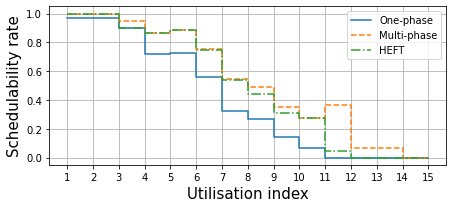

In [112]:
fig, ax = plt.subplots(figsize=(6.4, 3.0))

ax.set_xlabel("Utilisation index", fontsize=15)
ax.set_ylabel("Schedulability rate", fontsize=15)



plt.xticks(bins,["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"], fontsize=10)
# plt.xticks(bins,[u"0-1", "1-2", "2-3", "3-4", "4-5", "5-6", "6-7", "7-8", "8-9", "9-10", "10-11", "11-12", "12-13", "13-14", "14<"], fontsize=10, rotation=45)
# plt.xticks(bins,["≤1", "≤2", "≤3", "≤4", "≤5", "≤6", "≤7", "≤8", "≤9", "≤10", "10<"], fontsize=10)
#

# plt.plot(bin_data_crpd_0.keys(), bin_data_crpd_0.values(), '-.', label="CRPD 0%")
# plt.scatter(bin_data_crpd_0.keys(), bin_data_crpd_0.values())
#
# plt.plot(bin_data_crpd_1.keys(), bin_data_crpd_1.values(), '--', label="CRPD 1%")
# plt.scatter(bin_data_crpd_1.keys(), bin_data_crpd_1.values())
#
# plt.plot(bin_data_crpd_5.keys(), bin_data_crpd_5.values(), '--', label="CRPD 5%")
# plt.scatter(bin_data_crpd_5.keys(), bin_data_crpd_5.values())
#
# plt.plot(bin_data_crpd_10.keys(), bin_data_crpd_10.values(), '--', label="CRPD 10%")
# plt.scatter(bin_data_crpd_10.keys(), bin_data_crpd_10.values())
#
# plt.plot(bin_data_crpd_15.keys(), bin_data_crpd_15.values(), '--', label="CRPD 15%")
# plt.scatter(bin_data_crpd_15.keys(), bin_data_crpd_15.values())

keys = [1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15]

values_one = []
for v in bin_data_single.values():
    values_one += [v,v]

values_multi = []
for v in bin_data_crpd_20.values():
    values_multi += [v,v]

values_HEFT = []
for v in bin_data_crpd_15.values():
    values_HEFT += [v,v]

ax.plot(keys, values_one, label="One-phase")
ax.plot(keys, values_multi, '--', label="Multi-phase")
ax.plot(keys, values_HEFT, '-.', label="HEFT")

# ax.scatter(bin_data_single.keys(), bin_data_single.values())
# ax.plot(bin_data_single.keys(), bin_data_single.values(), label="One-phase")
# ax.scatter(bin_data_single.keys(), bin_data_single.values())
# ax.plot(bin_data_crpd_20.keys(), bin_data_crpd_20.values(), '--', label="Multi-phase")
# ax.scatter(bin_data_crpd_20.keys(), bin_data_crpd_20.values())


ax.grid()

ax.legend()
fig.tight_layout()
# plt.savefig("multi_vs_one.pdf", dpi=600)
plt.show()

In [106]:
three_phase_dir = "../3-phase-data-smaller/"

three_phase_dags = os.listdir(three_phase_dir)
# target_files = ["hFLS_output_100_6ms.txt", "SINGLE_PHASE.txt"]
target_files = ["hFLS_output_100_6ms.txt"]
# target_files = ["SINGLE_PHASE.txt"]
# target_files = ["hFLS_output_000_crpd.txt", "hFLS_output_001_crpd.txt", "hFLS_output_005.txt", "hFLS_output_010_crpd.txt", "hFLS_output_015_crpd.txt", "hFLS_output_020_crpd.txt", "SINGLE_PHASE.txt"]




for tf in target_files:
    dfs_delay_count = 0
    dfs_count = 0
    bfs_count = 0
    laxity_count = 0
    HEFT_count = 0
    percent_lax = []
    percent_bfs = []
    for dag in three_phase_dags:
        if "DAG" not in dag:
            continue

        DFS_delay = 0
        DFS = 0
        BFS = 0
        Laxity = 0
        makespan = 0
        HWFT=0

        file_path = os.path.join(three_phase_dir, dag, tf)
        with open(file_path, "r") as file:
            for line in file:
                if "DFSDelay" in line:
                    DFS_delay = int(get_num(line.split(" ")[7], True))
                elif "DFS" in line:
                    DFS = int(get_num(line.split(" ")[7], True))
                elif "BFS" in line:
                    BFS = int(get_num(line.split(" ")[7], True))
                elif "Laxity" in line:
                    Laxity = int(get_num(line.split(" ")[7], True))
                elif "HEFT" in line:
                    HEFT = int(get_num(line.split(" ")[7], True))
                elif "Makespan" in line:
                    makespan = int(line.split(" ")[1])



        if (Laxity == makespan):
            laxity_count +=1
            # percent_bfs.append(min((DFS/Laxity),(DFS_delay/Laxity)))
        elif(BFS == makespan):
            bfs_count +=1
            # percent_bfs.append(min((DFS/BFS),(DFS_delay/BFS)))
        elif(DFS == makespan):
            dfs_count += 1
            # percent_lax.append(min((Laxity/DFS),(BFS/DFS)))
        elif(DFS_delay == makespan):
            dfs_delay_count += 1
            # percent_lax.append(min((Laxity/DFS_delay),(BFS/DFS_delay)))
        elif(HEFT == makespan):
            HEFT_count += 1
            # percent_lax.append(min((Laxity/DFS_delay),(BFS/DFS_delay)))
            # percent_bfs?.append

        # percent_bfs.append(min(DFS_delay/))

    print(np.mean(percent_lax))
    print(np.mean(percent_bfs))
    # print(np.mean(percent_lax))
    print(tf)
    print("DFS delay: ", dfs_delay_count)
    print("DFS: ", dfs_count)
    print("BFS: ", bfs_count)
    print("Laxity: ", laxity_count)
    print("HEFT: ", HEFT_count)

nan
nan
hFLS_output_100_6ms.txt
DFS delay:  3
DFS:  15
BFS:  35
Laxity:  226
HEFT:  721


/home/julius/Programs/anaconda3/envs/rl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julius/Programs/anaconda3/envs/rl/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


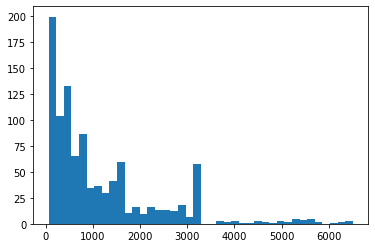

In [17]:
bfs_vs_dfs =

In [59]:
print(np.mean(list(bin_data_crpd_20.values())) - np.mean(list(bin_data_single.values())))

0.08632225883935696


In [118]:
three_phase_dir = "../3-phase-data-smaller/"

three_phase_dags = os.listdir(three_phase_dir)
target_files = ["hFLS_output_100_6ms.txt"]

for tf in target_files:
    runtime = 0
    for dag in three_phase_dags:
        if "DAG" not in dag:
            continue

        file_path = os.path.join(three_phase_dir, dag, tf)
        with open(file_path, "r") as file:
            for line in file:
                if "Schedule time" in line:
                    runtime = max(runtime, float(line.split(" ")[4]))




print(runtime)



    # print(np.mean(percent_lax))
    # print(np.mean(percent_bfs))
    # # print(np.mean(percent_lax))
    # print(tf)
    # print("DFS delay: ", dfs_delay_count)
    # print("DFS: ", dfs_count)
    # print("BFS: ", bfs_count)
    # print("Laxity: ", laxity_count)
    # print("HEFT: ", HEFT_count)

3865.98837
